In [125]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import folium
import csv
import io
import urllib.request
from datetime import datetime
import numpy as np

In [3]:
# TODOS
# change attempt to 0-1
# check for missing values in estimated_values (9999?, 0)
# check for outliers
# Normalize or bin "estimated_values"

# Put bike types with too little obsevations together to "other"
#  What to do with "Fahrrad" bike type
# Encode categorical values

# Data Loading

In [36]:
url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"

download = requests.get(url)
decoded_content = download.content.decode('ISO-8859-1')
file = decoded_content.splitlines()

# cr = csv.reader(file, delimiter=',')
cr = csv.DictReader(file, delimiter=',')
my_list = list(cr)
df = pd.DataFrame(my_list)

In [37]:
df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,27.02.2022,25.02.2022,18,27.02.2022,17,07300517,750,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,27.02.2022,26.02.2022,16,27.02.2022,09,05100315,399,Nein,Damenfahrrad,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...
2,27.02.2022,25.02.2022,22,27.02.2022,12,11200513,599,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3,27.02.2022,26.02.2022,23,27.02.2022,12,07200412,750,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,27.02.2022,26.02.2022,16,27.02.2022,09,03500932,1000,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


# Data Cleaning of the Bike Theft dataset

Cleaning steps: 
- Translation
- Duplicates
- Missing values
- outliers
- scaling
- balancing

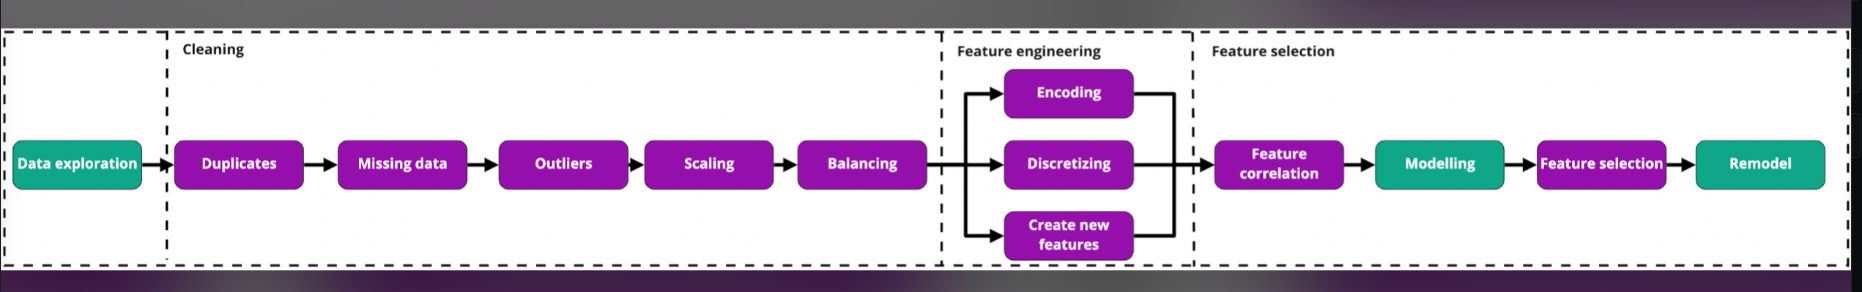

## Translation

### Translate column names

In [38]:
df.columns

Index(['ANGELEGT_AM', 'TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE',
       'TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE', 'LOR', 'SCHADENSHOEHE',
       'VERSUCH', 'ART_DES_FAHRRADS', 'DELIKT', 'ERFASSUNGSGRUND'],
      dtype='object')

In [39]:
eng_col_names = {
    "ANGELEGT_AM": "date_reported",
    "TATZEIT_ANFANG_DATUM": "date_theft_start",
    "TATZEIT_ANFANG_STUNDE": "hour_theft_start",
    "TATZEIT_ENDE_DATUM": "date_theft_end",
    "TATZEIT_ENDE_STUNDE": "hour_theft_end",
    "LOR": "LOR",
    "SCHADENSHOEHE": "estimated_value",
    "VERSUCH": "attempt",
    "ART_DES_FAHRRADS": "type_bike", 
    "DELIKT": "theft_type",
    "ERFASSUNGSGRUND": "theft_type_detail"    
}

In [40]:
df.rename(columns= eng_col_names, inplace=True)

In [41]:
df.columns

Index(['date_reported', 'date_theft_start', 'hour_theft_start',
       'date_theft_end', 'hour_theft_end', 'LOR', 'estimated_value', 'attempt',
       'type_bike', 'theft_type', 'theft_type_detail'],
      dtype='object')

### Translate categories

In [42]:
# pd.DataFrame(df[["type_bike", "attempt", "theft_type", "theft_type_detail"]].value_counts())

#### Type_bike

In [43]:
df["type_bike"].value_counts().keys()

Index(['Herrenfahrrad', 'Damenfahrrad', 'Fahrrad', 'Mountainbike',
       'Kinderfahrrad', 'diverse Fahrräder', 'Rennrad', 'Lastenfahrrad'],
      dtype='object')

In [44]:
# define function for renaming the categories
def rename_type_bike(x): 
    if x == "Herrenfahrrad": 
        return "man's bike"
    if x == "Damenfahrrad":
        return "woman's bike"
    if x == "Fahrrad":
        return "bike"
    if x == "Kinderfahrrad":
        return "child's bike"
    else: 
        return "other bike"

In [45]:
df["type_bike"] = df["type_bike"].apply(rename_type_bike)

In [46]:
df["type_bike"].value_counts()

man's bike      10092
woman's bike     6463
bike             2650
other bike       1795
child's bike      840
Name: type_bike, dtype: int64

#### attempt

In [47]:
df["attempt"].value_counts()

Nein         21748
Ja              85
Unbekannt        7
Name: attempt, dtype: int64

In [50]:
attempt_dict = {
    "Ja": "Yes", 
    "Nein": "No", 
    "Unbekannt": "Unknown"
}

In [53]:
# change "yes"/"no"/"unknown" to 0/1/"unknown"
df["attempt"] = df["attempt"].map(attempt_dict)

In [54]:
df["attempt"].value_counts()

No         21748
Yes           85
Unknown        7
Name: attempt, dtype: int64

#### Theft type and theft type detail

In [57]:
# Leaving in German for now

## Change dtypes

In [58]:
# convert the date columns
df["date_reported"] = pd.to_datetime(df["date_reported"], format='%d.%m.%Y')
df["date_theft_start"] = pd.to_datetime(df["date_theft_start"], format='%d.%m.%Y')
df["date_theft_end"] = pd.to_datetime(df["date_theft_end"], format='%d.%m.%Y')

# convert the time columns 
df["hour_theft_start"] = df["hour_theft_start"].astype(int)
df["hour_theft_end"] = df["hour_theft_end"].astype(int)


df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value              object
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [59]:
df["estimated_value"] = df["estimated_value"].astype(float)

In [60]:
df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value             float64
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

## Duplicates

In [62]:
df.duplicated().sum()

36

In [68]:
df = df.drop_duplicates()

## Missing data

In [70]:
df.isna().sum()

date_reported        0
date_theft_start     0
hour_theft_start     0
date_theft_end       0
hour_theft_end       0
LOR                  0
estimated_value      0
attempt              0
type_bike            0
theft_type           0
theft_type_detail    0
dtype: int64

In [74]:
df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value             float64
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [95]:
# check min and max for date and time columns
for col in list(df.columns[:5]):
    #print(col)
    print(f"min of {col}:  {df[col].min()}")
    print(f"max of {col}:  {df[col].max()}")

min of date_reported:  2021-01-01 00:00:00
max of date_reported:  2022-02-27 00:00:00
min of date_theft_start:  2021-01-01 00:00:00
max of date_theft_start:  2022-02-27 00:00:00
min of hour_theft_start:  0
max of hour_theft_start:  23
min of date_theft_end:  2021-01-01 00:00:00
max of date_theft_end:  2022-02-27 00:00:00
min of hour_theft_end:  0
max of hour_theft_end:  23


In [73]:
# check distribution of numerical variables 
df.describe()

,hour_theft_start,hour_theft_end,estimated_value
count,21804.000000,21804.000000,21804.000000
mean,14.522656,13.329939,904.648551
std,5.311098,5.248704,867.830176
min,0.000000,0.000000,0.000000
25%,10.000000,9.000000,400.000000
50%,16.000000,14.000000,649.000000
75%,19.000000,17.000000,1050.000000
max,23.000000,23.000000,9999.000000


### Estimated Value

Conclusion:  
- We have some bikes with "9999" as estimated value. These seem to be reasonable observations, that we'll keep
- We also have some bikes with "0" estimated value. These include both attempts and actually stolen bikes. 

--> Since we won't use estimated value for the first model, we will won't impute the "0" estimated value observations

In [115]:
df["estimated_value"].mode()

0    500.0
Name: estimated_value, dtype: float64

In [104]:
df["estimated_value"].sort_values(ascending= False).head(20)

1130     9999.0
4631     9999.0
2583     9588.0
13847    9500.0
3271     9420.0
10083    9000.0
9029     8450.0
10454    8449.0
20718    8400.0
19931    8027.0
18434    8000.0
7362     8000.0
20532    7999.0
2684     7990.0
8922     7899.0
5945     7871.0
5788     7798.0
4789     7700.0
9838     7500.0
14054    7500.0
Name: estimated_value, dtype: float64

In [107]:
df.sort_values(by = "estimated_value", ascending= False).head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail
1130,2022-02-03,2022-02-03,16,2022-02-03,16,11300722,9999.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4631,2021-11-16,2021-11-16,10,2021-11-16,11,11300723,9999.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2583,2021-12-29,2021-12-26,19,2021-12-29,15,09501737,9588.0,No,man's bike,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...
13847,2021-07-04,2021-07-04,16,2021-07-04,17,02400623,9500.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3271,2021-12-12,2021-12-11,19,2021-12-12,18,03601140,9420.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [ ]:
# Estimated value: values of "9999" seem reasonable. Could be the case that the one can only enter 4 digits

In [114]:
# check "0" values for estimated value
df.sort_values(by = "estimated_value", ascending= True).head(20)

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail
19586,2021-03-16,2021-03-15,16,2021-03-15,16,03701556,0.0,Yes,woman's bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
15758,2021-06-03,2021-06-03,6,2021-06-03,14,06200422,0.0,Yes,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
131,2022-02-23,2022-02-23,11,2022-02-23,18,10100311,0.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
7431,2021-10-06,2021-10-06,21,2021-10-06,21,01100310,0.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
13834,2021-07-04,2021-07-04,21,2021-07-04,21,08100105,0.0,Yes,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
390,2022-02-18,2022-02-18,1,2022-02-18,1,09502043,0.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
135,2022-02-23,2022-02-22,16,2022-02-23,14,02500834,0.0,No,bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
388,2022-02-18,2022-02-17,21,2022-02-17,21,08100417,0.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3968,2021-11-27,2021-11-26,21,2021-11-27,8,03200206,0.0,Yes,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
13251,2021-07-14,2021-07-14,8,2021-07-14,17,04300620,0.0,Yes,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [113]:
df[df["estimated_value"]==0].count()

date_reported        148
date_theft_start     148
hour_theft_start     148
date_theft_end       148
hour_theft_end       148
LOR                  148
estimated_value      148
attempt              148
type_bike            148
theft_type           148
theft_type_detail    148
dtype: int64

## Outliers

## Scaling


There is only one numerical variable (estimated value) that we could scale. As we don't use them right now, we can skip the scaling for now. 

# Save cleaned dataset

# Feature Engineering

## Concat date and time

In [113]:
# add minute and seconds to hour column 
df["hour_theft_start"] = df["hour_theft_start"].astype(str) + ":00:00"

In [118]:
df["hour_theft_end"]  = df["hour_theft_end"].astype(str) + ":00:00"

In [119]:
df["datetime_theft_start"] = df["date_theft_start"].astype(str) + " " + df["hour_theft_start"].astype(str)
df["datetime_theft_end"] = df["date_theft_end"].astype(str) + " " + df["hour_theft_end"].astype(str)

In [120]:
df["datetime_theft_start"] = pd.to_datetime(df["datetime_theft_start"]) 
df["datetime_theft_end"] = pd.to_datetime(df["datetime_theft_end"]) 

In [121]:
df.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,Weekday_theft_start,datetime_theft_start,datetime_theft_end
0,2022-02-27,2022-02-25,18:00:00,2022-02-27,17:00:00,07300517,750.0,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,4,2022-02-25 18:00:00,2022-02-27 17:00:00
1,2022-02-27,2022-02-26,16:00:00,2022-02-27,9:00:00,05100315,399.0,Nein,Damenfahrrad,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...,5,2022-02-26 16:00:00,2022-02-27 09:00:00
2,2022-02-27,2022-02-25,22:00:00,2022-02-27,12:00:00,11200513,599.0,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,4,2022-02-25 22:00:00,2022-02-27 12:00:00
3,2022-02-27,2022-02-26,23:00:00,2022-02-27,12:00:00,07200412,750.0,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,5,2022-02-26 23:00:00,2022-02-27 12:00:00
4,2022-02-27,2022-02-26,16:00:00,2022-02-27,9:00:00,03500932,1000.0,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,5,2022-02-26 16:00:00,2022-02-27 09:00:00


## Calculate time delta

In [126]:
df["Timedelta_theft_end_start"] = (df["datetime_theft_end"] - df["datetime_theft_start"]).astype('timedelta64[h]')

In [127]:
df.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,Weekday_theft_start,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start
0,2022-02-27,2022-02-25,18:00:00,2022-02-27,17:00:00,07300517,750.0,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,4,2022-02-25 18:00:00,2022-02-27 17:00:00,47.0
1,2022-02-27,2022-02-26,16:00:00,2022-02-27,9:00:00,05100315,399.0,Nein,Damenfahrrad,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...,5,2022-02-26 16:00:00,2022-02-27 09:00:00,17.0
2,2022-02-27,2022-02-25,22:00:00,2022-02-27,12:00:00,11200513,599.0,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,4,2022-02-25 22:00:00,2022-02-27 12:00:00,38.0
3,2022-02-27,2022-02-26,23:00:00,2022-02-27,12:00:00,07200412,750.0,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,5,2022-02-26 23:00:00,2022-02-27 12:00:00,13.0
4,2022-02-27,2022-02-26,16:00:00,2022-02-27,9:00:00,03500932,1000.0,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,5,2022-02-26 16:00:00,2022-02-27 09:00:00,17.0


<AxesSubplot:xlabel='Timedelta_theft_end_start', ylabel='estimated_value'>

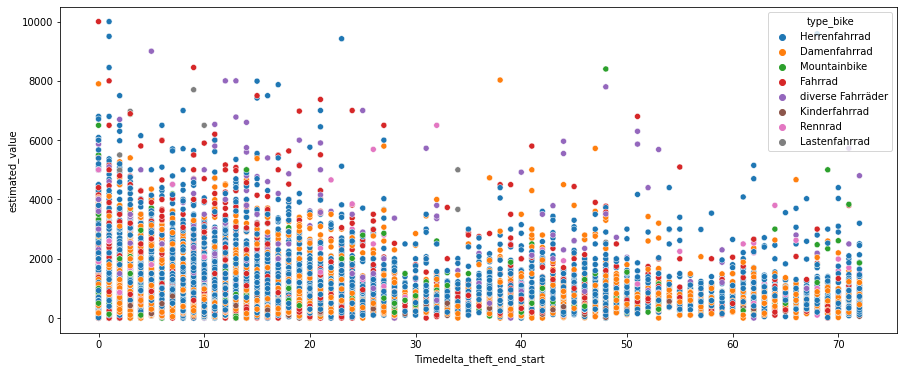

In [130]:
plt.figure(figsize = (15, 6))
sns.scatterplot(data = df, x = "Timedelta_theft_end_start", y = "estimated_value", hue ="type_bike")

<AxesSubplot:xlabel='Timedelta_theft_end_start', ylabel='Count'>

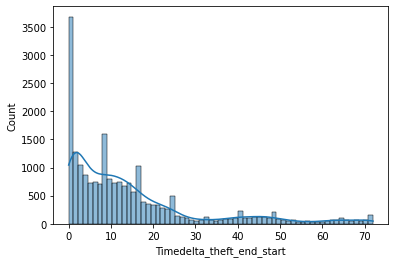

In [133]:
sns.histplot(x = df["Timedelta_theft_end_start"], kde = True)

In [137]:
df[df["Timedelta_theft_end_start"] == 0].count()

date_reported                2178
date_theft_start             2178
hour_theft_start             2178
date_theft_end               2178
hour_theft_end               2178
LOR                          2178
estimated_value              2178
attempt                      2178
type_bike                    2178
theft_type                   2178
theft_type_detail            2178
Weekday_theft_start          2178
datetime_theft_start         2178
datetime_theft_end           2178
Timedelta_theft_end_start    2178
dtype: int64

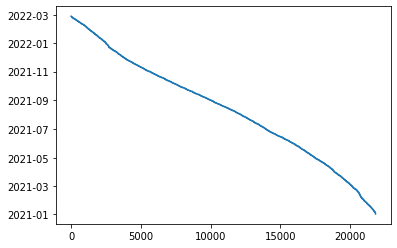

In [ ]:
# Conclusion: Timedelta between theft start and end doesn't give any meaningfull insights.
#  Caclulating whether the bike was stolen during the day or at night is not possible, as we have many timedeltas
#  > 24 hours. 

## Extracting higher levels from LOR

In [41]:
# BZR (first six numbers)
df["BZR"] = df["LOR"].str[:6]

In [42]:
# PGR (first four numbers)
df["PGR"] = df["LOR"].str[:4]

In [43]:
# Bezirk (first four numbers)
df["Bezirk"] = df["LOR"].str[:2]